<a href="https://colab.research.google.com/github/sanjay2097/Topic-Modeling-on-News-Articles/blob/main/Topic_Modeling_on_News_Articles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Extraction/identification of major topics & themes discussed in news articles. </u></b>

## <b> Problem Description </b>

### In this project your task is to identify major themes/topics across a collection of BBC news articles. You can use clustering algorithms such as Latent Dirichlet Allocation (LDA), Latent Semantic Analysis (LSA) etc.

## <b> Data Description </b>

### The dataset contains a set of news articles for each major segment consisting of business, entertainment, politics, sports and technology. You need to create an aggregate dataset of all the news articles and perform topic modeling on this dataset. Verify whether these topics correspond to the different tags available.

In [1]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Import libraries
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import re,random,os
import seaborn as sns
from nltk.corpus import stopwords
import string
from pprint import pprint as pprint

# Gensim for LDA
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [2]:
# spacy for basic processing, optional, can use nltk as well(lemmatisation etc.)
import spacy
spacy.cli.download('en')

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [3]:
pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 5.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=4a2f5e03f0d1e41e62bcd95f1b87258dce9e09b30a0adf644532dc9f62e7a748
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [4]:
#plotting tools
import pyLDAvis
from pyLDAvis import gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Reading the BBC news dataset
data_folder='/content/drive/MyDrive/News Articles'
folders=["business","entertainment","politics","sport","tech"]
x=[]
y=[]


for i in folders:
    files=os.listdir(data_folder+'/'+i)
    for text_file in files:
        file_path=data_folder + '/'+i+'/'+text_file
        with open(file_path,'r',encoding='utf-8', errors='ignore') as f:
            data=f.read()
        x.append(data)
        y.append(i)
        
data={'news':x,'type':y}
df = pd.DataFrame(data)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2216 entries, 0 to 2215
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   news    2216 non-null   object
 1   type    2216 non-null   object
dtypes: object(2)
memory usage: 34.8+ KB


In [8]:
df.head(10)

,news,type
0,China keeps tight rein on credit\n\nChina's ef...,business
1,Call centre users 'lose patience'\n\nCustomers...,business
2,"Steel firm 'to cut' 45,000 jobs\n\nMittal Stee...",business
3,Peugeot deal boosts Mitsubishi\n\nStruggling J...,business
4,Air passengers win new EU rights\n\nAir passen...,business
5,Telegraph newspapers axe 90 jobs\n\nThe Daily ...,business
6,Yukos unit buyer faces loan claim\n\nThe owner...,business
7,Court rejects $280bn tobacco case\n\nA US gove...,business
8,US trade gap hits record in 2004\n\nThe gap be...,business
9,Mixed signals from French economy\n\nThe Frenc...,business


In [9]:
df.news[0]

'China keeps tight rein on credit\n\nChina\'s efforts to stop the economy from overheating by clamping down on credit will continue into 2005, state media report.\n\nThe curbs were introduced earlier this year to ward off the risk that rapid expansion might lead to soaring prices. There were also fears that too much stress might be placed on the fragile banking system. Growth in China remains at a breakneck 9.1%, and corporate investment is growing at more than 25% a year. The breakneck pace of economic expansion has kept growth above 9% for more than a year. Rapid tooling-up of China\'s manufacturing sector means a massive demand for energy - one of the factors which has kept world oil prices sky-high for most of this year. In theory, the government has a 7% growth target, but continues to insist that the overshoot does not mean a "hard landing" in the shape of an overbalancing economy. A low exchange rate - China\'s yuan is pegged to a rate of 8.28 to the dollar, which seems to be in

In [10]:
df.shape

(2216, 2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


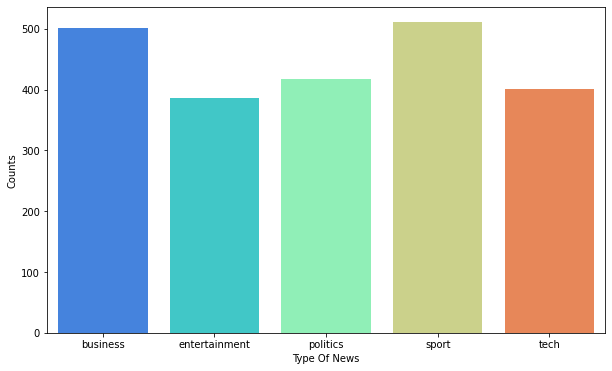

In [11]:
# Countplot for types of news 
plt.figure(figsize=(10,6))
sns.countplot(df['type'], data=df , palette ='rainbow')
plt.xlabel("Type Of News")
plt.ylabel("Counts")
plt.show()

##**Data preprocessing**

####Before we can use our data to build a model we need to prepare it to a form that will be understood by the LDA algorithm.It can be done by building a matrix that has documents for rows and a bag of words (list of all words from the corpus) for columns. That way defining a count of certain words in each document. To achieve a better performance will also clean the input data so that the maximum amount of information can be represented as the smallest matrix possible.

##**Tokenization**
####Since we imported the corpus, now we will tokenize each document. We will also lowercase all the words and remove nonalphabetic characters from them. We do that so we can count the number of certain words in each document later on. We see now that rare words or word variations contain relevant information as they would just be the tail of our distribution.

### **Normalization**
####One of the key steps in processing language data is to remove noise so that the machine can more easily detect the patterns in the data. Text data contains a lot of noise, this takes the form of special characters such as hashtags, punctuation and numbers. All of which are difficult for computers to understand if they are present in the data. We need to, therefore, process the data to remove these elements.

In [12]:
# Define function for text cleaning
import re
def  clean_text(df, text_col):
    df[text_col] = df[text_col].str.lower()
    #remove punctuations and url text
    df[text_col] = df[text_col].apply(lambda x: re.sub(r"\n\n", " ", x))
    df[text_col] = df[text_col].apply(lambda x: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", x))  
    # remove numbers
    df[text_col] = df[text_col].apply(lambda x: re.sub(r"\d+", "", x))
    #remove extra spaces
    df[text_col] = df[text_col].apply(lambda x: x.replace('  ',' '))
    
    return df
# Applying function
new_df = clean_text(df, 'news')
new_df.head(10)

,news,type
0,china keeps tight rein on credit chinas effort...,business
1,call centre users lose patience customers tryi...,business
2,steel firm to cut jobs mittal steel one of the...,business
3,peugeot deal boosts mitsubishi struggling japa...,business
4,air passengers win new eu rights air passenger...,business
5,telegraph newspapers axe jobs the daily and su...,business
6,yukos unit buyer faces loan claim the owners o...,business
7,court rejects bn tobacco case a us government ...,business
8,us trade gap hits record in the gap between us...,business
9,mixed signals from french economy the french e...,business


In [13]:
new_df.news[0]

'china keeps tight rein on credit chinas efforts to stop the economy from overheating by clamping down on credit will continue into state media report the curbs were introduced earlier this year to ward off the risk that rapid expansion might lead to soaring prices there were also fears that too much stress might be placed on the fragile banking system growth in china remains at a breakneck and corporate investment is growing at more than a year the breakneck pace of economic expansion has kept growth above for more than a year rapid toolingup of chinas manufacturing sector means a massive demand for energy one of the factors which has kept world oil prices skyhigh for most of this year in theory the government has a growth target but continues to insist that the overshoot does not mean a hard landing in the shape of an overbalancing economy a low exchange rate chinas yuan is pegged to a rate of to the dollar which seems to be in relentless decline means chinese exports are cheap on wo

In [14]:
# list of stopwords from nltk
nltk.download('stopwords')
stopwords_nltk = list(stopwords.words('english'))

# list of stopwords from spacy
sp = spacy.load('en_core_web_sm')
stopwords_spacy = list(sp.Defaults.stop_words)

# unique stopwords from all stopwords
all_stopwords = []
all_stopwords.extend(stopwords_nltk)
all_stopwords.extend(stopwords_spacy)
# all stop words
all_stopwords = list(set(all_stopwords))

def remove_stopwords(text):  
  text = [wd.lower() for wd in text.split() if wd.lower() not in all_stopwords]
  return " ".join(text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


In [15]:
new_df['news'] = new_df['news'].apply(remove_stopwords)

In [16]:
# Remove duplicate values
new_df.drop_duplicates(inplace=True)

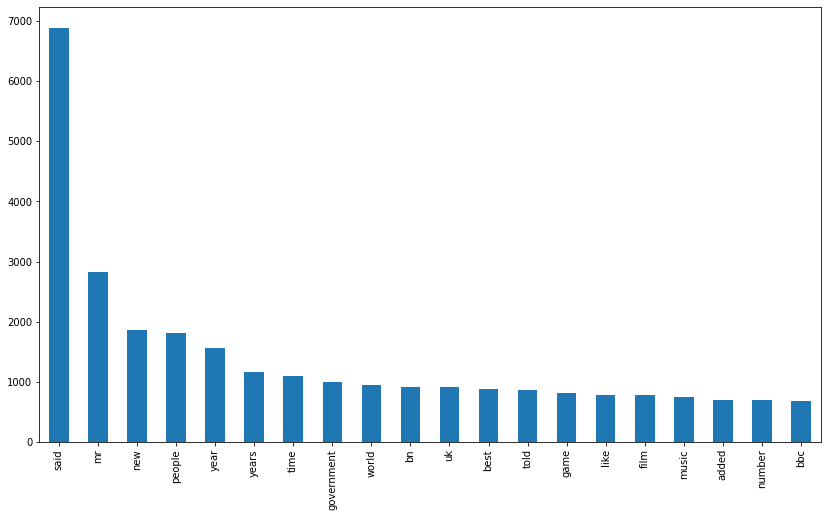

In [17]:
# bar plot of frequent words
plt.figure(figsize=(14,8))
pd.Series(' '.join(new_df['news']).split()).value_counts()[:20].plot.bar()
plt.show()

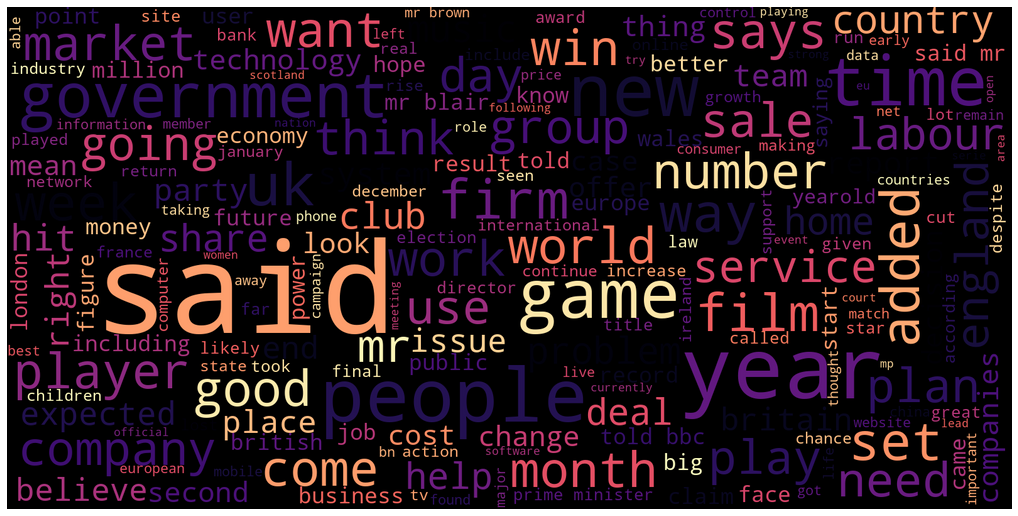

In [18]:
# Create word cloud for all dataset
from wordcloud import WordCloud
text = " ".join(new_df.news)
wordcloud = WordCloud(width=1600, height=800,max_font_size=200, colormap='magma').generate(text)

plt.figure(figsize = (18, 16))
plt.imshow(wordcloud, interpolation='spline36')
plt.axis("off")
plt.show()

In [19]:
# Create new column word count of sentence
new_df['word_count'] = new_df['news'].apply(lambda x: len(str(x).split(" ")))
df.head()

,news,type,word_count
0,china keeps tight rein credit chinas efforts s...,business,119
1,centre users lose patience customers trying ce...,business,304
2,steel firm cut jobs mittal steel worlds larges...,business,137
3,peugeot deal boosts mitsubishi struggling japa...,business,165
4,air passengers win new eu rights air passenger...,business,322


Text(0, 0.5, 'News Topic')

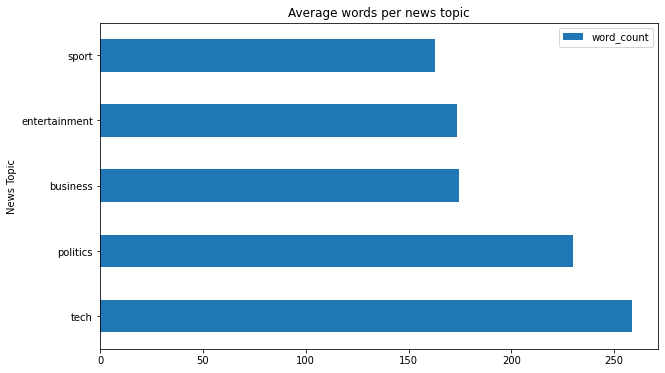

In [20]:
#average word count per topic
pd.DataFrame(new_df.groupby(["type"])['word_count'].agg(np.mean).sort_values(ascending=False)).plot(kind = 'barh',
              title = 'Average words per news topic', figsize=(10,6))
plt.ylabel("News Topic")

In [21]:
# Tokenize using gensims simple_preprocess
def sent_to_words(sentences, deacc=True):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence)))

In [22]:
# Functions for lemmatization
def lemmatization(texts,allowed_postags=['NOUN','ADJ','VERB','ADV']):
    """https://spacy.io/api/annotation"""
    texts_out=[]
    for sent in texts:
        doc=nlp(' '.join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [23]:
# convert to list
data=new_df['news'].values.tolist()
data_words=list(sent_to_words(data))

#lemmatize
nlp = spacy.load('en_core_web_sm', disable=['parser','ner'])
data_lemmatized = lemmatization(data_words,allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# create dictionary
id2word = corpora.Dictionary(data_lemmatized)

#create corpus
texts = data_lemmatized

#term document frequency
corpus = [id2word.doc2bow(text) for text in texts]

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: Sele

## LDA Model

In [24]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel( corpus=corpus, id2word=id2word, num_topics=10, random_state=100, update_every=1,
                                             chunksize=1000, passes=10, alpha='auto', per_word_topics=True )

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [25]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.023*"say" + 0.016*"mobile" + 0.014*"people" + 0.014*"technology" + '
  '0.013*"phone" + 0.012*"game" + 0.012*"music" + 0.008*"video" + 0.008*"new" '
  '+ 0.008*"tv"'),
 (1,
  '0.025*"say" + 0.021*"network" + 0.017*"legal" + 0.015*"file" + '
  '0.013*"company" + 0.010*"firm" + 0.009*"broadband" + 0.009*"court" + '
  '0.008*"service" + 0.008*"action"'),
 (2,
  '0.027*"say" + 0.013*"year" + 0.011*"rise" + 0.010*"growth" + 0.009*"market" '
  '+ 0.009*"economy" + 0.008*"foreign" + 0.008*"price" + 0.008*"rate" + '
  '0.007*"government"'),
 (3,
  '0.021*"say" + 0.015*"year" + 0.010*"firm" + 0.009*"company" + 0.008*"share" '
  '+ 0.007*"big" + 0.006*"cost" + 0.006*"offer" + 0.005*"business" + '
  '0.005*"developer"'),
 (4,
  '0.036*"gadget" + 0.014*"list" + 0.011*"portable" + 0.010*"number" + '
  '0.009*"lose" + 0.009*"device" + 0.008*"way" + 0.008*"include" + '
  '0.007*"player" + 0.007*"leave"'),
 (5,
  '0.028*"game" + 0.021*"play" + 0.017*"say" + 0.012*"time" + 0.009*"player" + '


In [26]:
# Compute Perplexity
# a measure of how good the model is.Lower the better.
perpex = lda_model.log_perplexity(corpus)
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [27]:
print('\nPerplexity: ', perpex)
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.872239275830527

Coherence Score:  0.4499300518641748


In [28]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.013797  0.134317       1        1  21.246942
5      0.127641  0.016321       2        1  16.819113
3     -0.022967  0.091978       3        1  12.420147
7      0.160524  0.051625       4        1  11.045972
0     -0.036441 -0.086908       5        1  10.658787
2     -0.024392  0.188629       6        1  10.436989
9     -0.089484 -0.035121       7        1   7.740738
6     -0.169303 -0.177407       8        1   4.279837
1     -0.191322 -0.001636       9        1   3.437424
4      0.231947 -0.181800      10        1   1.914050, topic_info=        Term         Freq        Total Category  logprob  loglift
1199    game  1814.000000  1814.000000  Default  30.0000  30.0000
1244    play  1262.000000  1262.000000  Default  29.0000  29.0000
226      say  7123.000000  7123.000000  Default  28.0000  28.0000
176   mobile   540.000000   540.000000  Default  27.0000  27.0000
453   people  1908.000000  1908.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
86      year    24.335997  2290.657820  Topic10  -5.4443  -0.5887
245     time    24.009296  1261.117611  Topic10  -5.4579  -0.0054
998     live    23.288863   307.036238  Topic10  -5.4883   1.3770
453   people    23.586684  1908.224637  Topic10  -5.4756  -0.4373
146     good    23.572679  1062.185505  Topic10  -5.4762   0.1480

[733 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1379      4  0.027146  accelerate
1379      6  0.950107  accelerate
6506      4  0.969756     acclaim
477       1  0.224114      action
477       2  0.204256      action
...     ...       ...         ...
86        6  0.168511        year
86        7  0.054569        year
86        8  0.008731        year
86        9  0.004366        year
86       10  0.010477        year

[2038 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 6, 4, 8, 1, 3, 10, 7, 2, 5])

## LDAMallet Model

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip /content/mallet-2.0.8.zip
mallet_path = '/content/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word , workers=6)

In [30]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

[(0,
  [('good', 0.0352039594475932),
   ('film', 0.03005508102498603),
   ('year', 0.0225113754290732),
   ('include', 0.021753013490859743),
   ('music', 0.01808094515845773),
   ('award', 0.017003272930470183),
   ('star', 0.010936377424762512),
   ('release', 0.009499481120779116),
   ('actor', 0.009060429472339745),
   ('role', 0.008421808892791571)]),
 (1,
  [('set', 0.02553940995156319),
   ('year', 0.021312197269925143),
   ('win', 0.020343461030383092),
   ('time', 0.017877586966094233),
   ('week', 0.01712901805372083),
   ('open', 0.01690885072655218),
   ('run', 0.014751210920299428),
   ('final', 0.013606340819022457),
   ('world', 0.01325407309555262),
   ('start', 0.011712901805372083)]),
 (2,
  [('player', 0.022439976245015696),
   ('play', 0.0223975566301858),
   ('team', 0.014592347501484686),
   ('game', 0.013871214049376432),
   ('add', 0.012471366759989819),
   ('minute', 0.011538135233732079),
   ('club', 0.010138287944345466),
   ('lead', 0.009374734877407313),
 

In [31]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = round(coherence_model_ldamallet.get_coherence(),3)
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.532


In [32]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, alpha=0.6)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [33]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=5, limit=20, step=1)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is

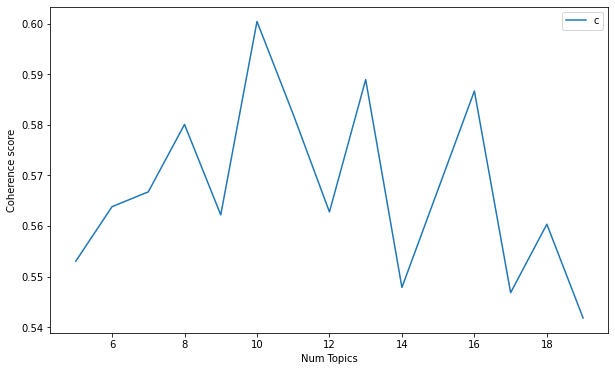

In [34]:
# Show graph
limit=20
start=5 
step=1
plt.figure(figsize=(10,6))
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [35]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Topic =", m, " has Coherence Value of", round(cv, 3))

Topic = 5  has Coherence Value of 0.553
Topic = 6  has Coherence Value of 0.5638
Topic = 7  has Coherence Value of 0.5667
Topic = 8  has Coherence Value of 0.5801
Topic = 9  has Coherence Value of 0.5622
Topic = 10  has Coherence Value of 0.6004
Topic = 11  has Coherence Value of 0.5821
Topic = 12  has Coherence Value of 0.5628
Topic = 13  has Coherence Value of 0.5889
Topic = 14  has Coherence Value of 0.5478
Topic = 15  has Coherence Value of 0.5673
Topic = 16  has Coherence Value of 0.5867
Topic = 17  has Coherence Value of 0.5468
Topic = 18  has Coherence Value of 0.5603
Topic = 19  has Coherence Value of 0.5418


In [39]:
# Select the model and print the topics
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.013*"law" + 0.011*"rule" + 0.011*"case" + 0.009*"government" + '
  '0.009*"police" + 0.009*"court" + 0.008*"charge" + 0.007*"legal" + '
  '0.007*"trial" + 0.006*"claim"'),
 (1,
  '0.017*"people" + 0.017*"user" + 0.015*"site" + 0.015*"software" + '
  '0.014*"net" + 0.012*"search" + 0.012*"system" + 0.010*"email" + '
  '0.010*"firm" + 0.010*"information"'),
 (2,
  '0.020*"game" + 0.017*"people" + 0.017*"phone" + 0.015*"mobile" + '
  '0.015*"technology" + 0.009*"service" + 0.008*"video" + 0.008*"player" + '
  '0.008*"year" + 0.007*"tv"'),
 (3,
  '0.024*"year" + 0.020*"rise" + 0.015*"growth" + 0.014*"economy" + '
  '0.014*"price" + 0.014*"rate" + 0.013*"market" + 0.012*"fall" + '
  '0.011*"economic" + 0.011*"high"'),
 (4,
  '0.039*"film" + 0.026*"good" + 0.019*"award" + 0.017*"year" + 0.012*"actor" '
  '+ 0.012*"include" + 0.011*"star" + 0.008*"role" + 0.007*"director" + '
  '0.007*"show"'),
 (5,
  '0.020*"play" + 0.018*"game" + 0.016*"player" + 0.015*"win" + 0.012*"year" + '
  '

In [40]:
# Visualize the topics
from gensim.models.ldamodel import LdaModel
def convertldaMalletToldaGen(mallet_model):
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha) # original function has 'eta=0' argument
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

ldagensim = convertldaMalletToldaGen(optimal_model)

import pyLDAvis.gensim_models as gensimvis
vis_data = gensimvis.prepare(ldagensim, corpus, id2word, sort_topics=False)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


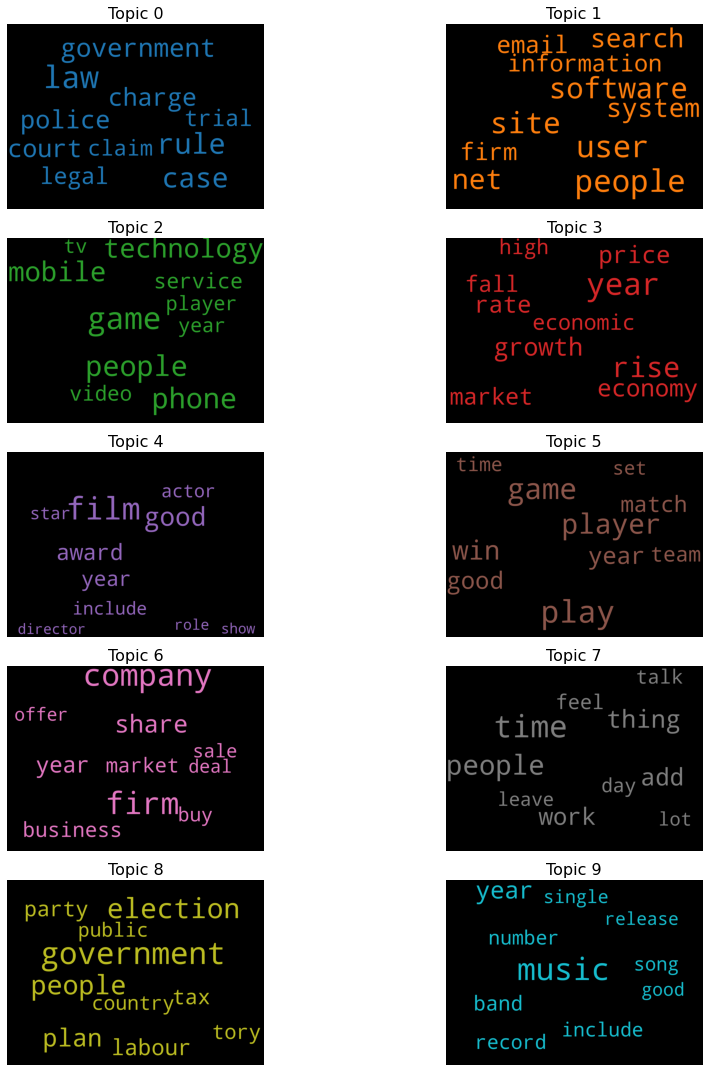

In [42]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords,
                  
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='magma',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

##**Conclusion**

###**We started with understanding what topic modeling can do. We built a basic topic model using Gensim’s LDA and visualize the topics using pyLDAvis. Then we built mallet’s LDA implementation. We saw how to find the optimal number of topics using coherence scores and how we can come to a logical understanding of how to choose the optimal model.Finally we saw how to aggregate and present the results to generate insights that may be in a more actionable.**